# The deep learning hello world

### Highly inspired by @martin_gorner's tutorial:

[Tensorflow and deep learning, without a PhD](https://www.youtube.com/watch?v=qyvlt7kiQoI)

Full code at https://github.com/martin-gorner/tensorflow-mnist-tutorial

In [1]:
import tensorflow as tf
import tensorflowvisu
from tensorflow.examples.tutorials.mnist import input_data as mnist_data

print("Tensorflow version " + tf.__version__)
tf.set_random_seed(0)

Tensorflow version 1.1.0


In [2]:
# Download images and labels into mnist.test (10K images+labels)
# and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data",
                                  one_hot=True,
                                  reshape=False,
                                  validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [63]:
mnist.train.images[3]

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [

In [62]:
mnist.train.labels[3]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

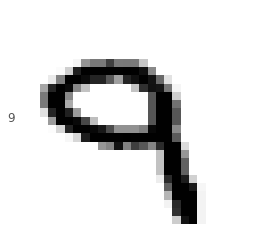

In [61]:
from matplotlib import pyplot as plt
import numpy as np

def show_minst_digit(digit, label=''):
    plt.imshow(1-digit.reshape((28, 28)), cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(label, rotation='0')
    #plt.show()

show_minst_digit(mnist.train.images[3], np.argmax(mnist.train.labels[3]))

## Simplest model: perceptron

![Simple perceptron for MNIST digits](img/mnist-perceptron.png)

## Activation function: softmax

$$ \mathrm{softmax}(L_n) = \frac{\mathrm e^{L_n}}{|| \mathrm e^{L}||} $$

Because we want the output to describe a probability distribution

![Batch perceptron for MNIST digits](img/mnist-batch-perceptron.png)

![Tensor dimension](img/mnist-perceptron-tensors.png)

In [4]:
# input X: 28x28 grayscale images,
# the first dimension (None) will index the images in the mini-batch

X = tf.placeholder(tf.float32, [None, 28, 28, 1])

# correct answers will go here (T stands for 'target')
T = tf.placeholder(tf.float32, [None, 10])

# weights W[784, 10]   784=28*28
W = tf.Variable(tf.zeros([784, 10]))

# biases b[10]
b = tf.Variable(tf.zeros([10]))

# flatten the images into a single line of pixels
# -1 in the shape definition means "the only possible
# dimension that will preserve the number of elements"

X_flat = tf.reshape(X, [-1, 784])

# The model
Y = tf.nn.softmax(tf.matmul(X_flat, W) + b)

## Loss function: cross-entropy
### aka divergence, Kullback-Leibler distance, ...

![cross-entropy](img/cross-entropy.png)

Because we want to measure the distance between two probability distributions

In [5]:
# log takes the log of each element,
# * multiplies the tensors element by element
# reduce_mean will add all the components in the tensor
# so here we end up with the total cross-entropy for all images in the batch
cross_entropy = -tf.reduce_mean(T * tf.log(Y)) * 1000.0

# normalized for batches of 100 images,
# *10 because  "mean" included an unwanted division by 10

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(T, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training, learning rate = 0.005
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)

allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])

incorrect_prediction = tf.squeeze(tf.where(tf.logical_not(tf.equal(tf.argmax(Y,1), tf.argmax(T,1)))))

# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [6]:
# You can call this function in a loop to train the model, 100 images at a time
def training_step(i):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values
    a_train, c_train, weights, bias = sess.run([accuracy, cross_entropy, allweights, allbiases],
                                feed_dict={X: batch_X, T: batch_Y})

    # compute test values
    a_test, c_test = sess.run([accuracy, cross_entropy],
                              feed_dict={X: mnist.test.images,
                                         T: mnist.test.labels})

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, T: batch_Y})
    
    incorrect, predictions = sess.run([incorrect_prediction, Y],
                       feed_dict={X: mnist.test.images,
                                  T: mnist.test.labels})
    return (a_train, c_train, a_test, c_test, weights, bias, incorrect, predictions)

In [7]:
num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

In [8]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test, weights, biases, incorrect, predictions = results_tr

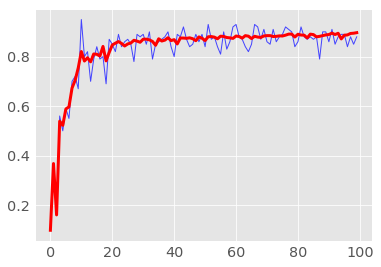

In [9]:
%matplotlib inline

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [10]:
a_test[-1]

0.89679998

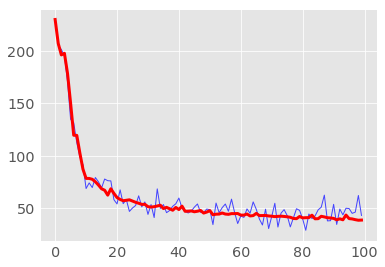

In [11]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

In [12]:
incorrect = incorrect[-1]
prediction = predictions[-1]

def get_class(v):
    return np.argmax(v)

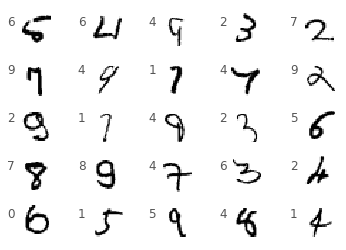

In [13]:
for p in range(25):
    plt.subplot(5, 5, 1+p)
    show_minst_digit(mnist.test.images[incorrect[p]],
                     get_class(prediction[incorrect[p]]))

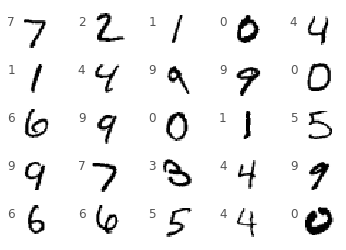

In [14]:
correct = list(set(range(len(predictions))) - set(incorrect))
for p in range(25):
    plt.subplot(5, 5, 1+p)
    show_minst_digit(mnist.test.images[correct[p]],
                     get_class(mnist.test.labels[correct[p]]))

## Multi-layer perceptron (i.e. _deep learning_)

![Five layers network](img/5-layer-net.png)

In [15]:
# five layers and their number of neurons
# (the last layer has 10 softmax neurons)
L = 200
M = 100
N = 60
O = 30

# Weights initialised with small random values between -0.2 and +0.2
W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([L]))
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.zeros([M]))
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.zeros([N]))
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.zeros([O]))
W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

# The model

Y1 = tf.nn.sigmoid(tf.matmul(X_flat, W1) + B1)
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

# TensorFlow provides the softmax_cross_entropy_with_logits function
# to avoid numerical stability problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits,
                                                        labels=T)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(T, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training step, learning rate = 0.003
learning_rate = 0.003
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)


incorrect_prediction = tf.squeeze(tf.where(tf.logical_not(tf.equal(tf.argmax(Y,1), tf.argmax(T,1)))))

# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [16]:
num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

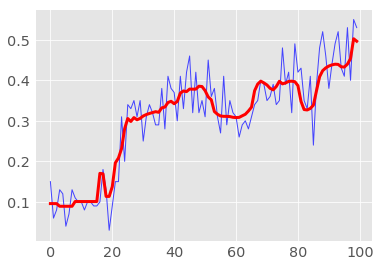

In [17]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test, weights, biases, incorrect, predictions = results_tr

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [18]:
a_test[-1]

0.4964

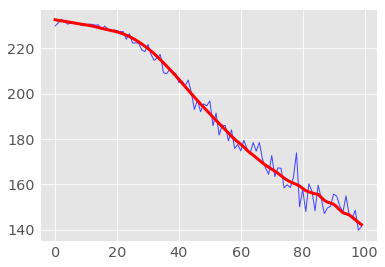

In [19]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

## From sigmoid to relu

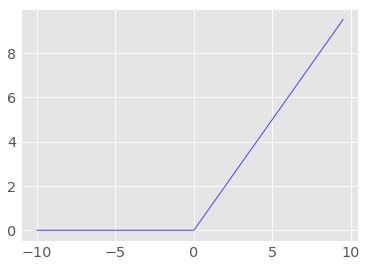

In [69]:
def relu(x):
    return max(0, x)

x_vals = np.arange(-10, 10, .5)
plt.plot(x_vals, list(map(relu, x_vals)))
plt.show()

Derivative of relu in 0? Either fix a value or use _softplus_

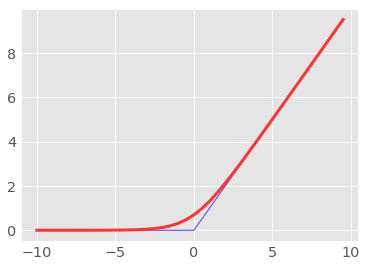

In [74]:
def softplus(x):
    return  math.log(1.0 + math.e**x)

plt.plot(x_vals, list(map(relu, x_vals)))
plt.plot(x_vals, list(map(softplus, x_vals)))
plt.show()

(by the way, note that $\mathrm{softplus}'(x)=\mathrm{sigmoid}(x)$)

In [26]:
# Weights initialised with small random values between -0.2 and +0.2
# When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.ones([L])/10)
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.ones([M])/10)
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.ones([N])/10)
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.ones([O])/10)
W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

Y1 = tf.nn.relu(tf.matmul(X_flat, W1) + B1)
Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

def training_step(i):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values
    a_train, c_train, weights, bias = sess.run([accuracy, cross_entropy, allweights, allbiases],
                                feed_dict={X: batch_X, T: batch_Y})

    # compute test values
    a_test, c_test = sess.run([accuracy, cross_entropy],
                              feed_dict={X: mnist.test.images,
                                         T: mnist.test.labels})

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, T: batch_Y})

    return (a_train, c_train, a_test, c_test, weights, bias)

In [27]:
num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

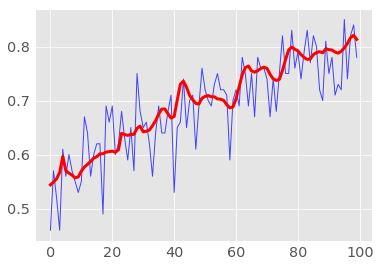

In [29]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test, weights, biases = results_tr

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [30]:
a_test[-1]

0.8132

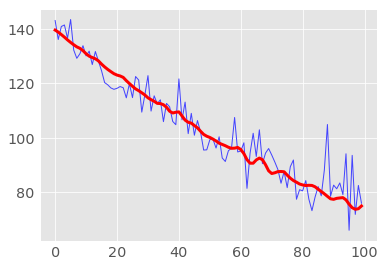

In [31]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

![improvement from sigmoid to relu](img/from-sigmoid-to-relu.png)

![Effects of a too high learning rate](img/relu-jumps.png)

## Variable learning rate

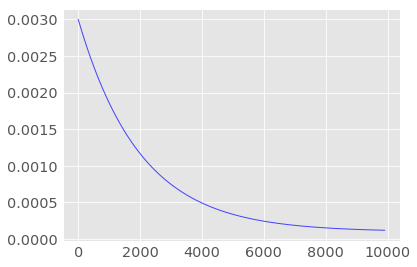

In [46]:
max_learning_rate = 0.003
min_learning_rate = 0.0001
decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
iterations = np.arange(1, 10000, 100)
lrs = [min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
       for i in iterations]
plt.plot(iterations, lrs)
plt.show()

In [41]:
import math

# variable learning rate
lr = tf.placeholder(tf.float32)


# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)

def training_step(i):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # compute training values
    a_train, c_train = sess.run([accuracy, cross_entropy],
                                feed_dict={X: batch_X, T: batch_Y})

    # compute test values
    a_test, c_test = sess.run([accuracy, cross_entropy],
                              feed_dict={X: mnist.test.images,
                                         T: mnist.test.labels})

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, T: batch_Y, lr: learning_rate})

    return (a_train, c_train, a_test, c_test)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

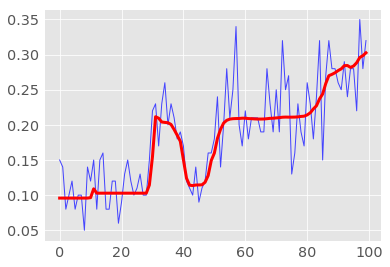

In [42]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test = results_tr

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [43]:
a_test[-1]

0.3026

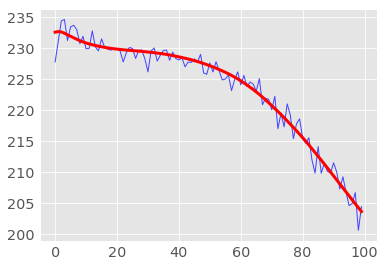

In [44]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

![Overfitting](img/overfitting.png)

## Regularization

![Dropout](img/dropout.png))

In [47]:
pkeep = tf.placeholder(tf.float32)

# The model, with dropout at each layer
XX = tf.reshape(X, [-1, 28*28])

Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
Y1d = tf.nn.dropout(Y1, pkeep)

Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
Y2d = tf.nn.dropout(Y2, pkeep)

Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
Y3d = tf.nn.dropout(Y3, pkeep)

Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)

Ylogits = tf.matmul(Y4d, W5) + B5
Y = tf.nn.softmax(Ylogits)

def training_step(i):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    
    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # compute training values
    a_train, c_train = sess.run([accuracy, cross_entropy],
                                feed_dict={X: batch_X,
                                           T: batch_Y,
                                           pkeep: 1.0})

    # compute test values
    a_test, c_test = sess.run([accuracy, cross_entropy],
                              feed_dict={X: mnist.test.images,
                                         T: mnist.test.labels,
                                         pkeep: 1.0})

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X,
                                    T: batch_Y,
                                    lr: learning_rate,
                                    pkeep: 0.75})

    return (a_train, c_train, a_test, c_test)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

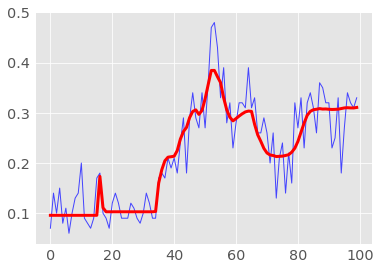

In [48]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test = results_tr

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [49]:
a_test[-1]

0.3107

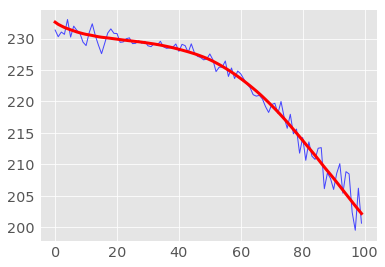

In [50]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

![Dropout results](img/dropout-results.png)

## Convolutional networks

![Convolution](img/convolutional-network.png)

![Used convolutional network](img/convolutional-architecture.png)

In [51]:
# three convolutional layers with their channel counts, and a
# fully connected layer (tha last layer has 10 softmax neurons)
K = 4  # first convolutional layer output depth
L = 8  # second convolutional layer output depth
M = 12  # third convolutional layer
N = 200  # fully connected layer

W1 = tf.Variable(tf.truncated_normal([5, 5, 1, K], stddev=0.1))  # 5x5 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.ones([K])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.ones([L])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.ones([M])/10)

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.ones([N])/10)
W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

# The model
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

In [52]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

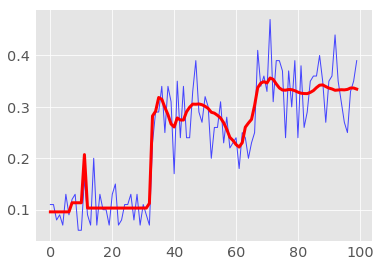

In [53]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test = results_tr

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [54]:
a_test[-1]

0.3346

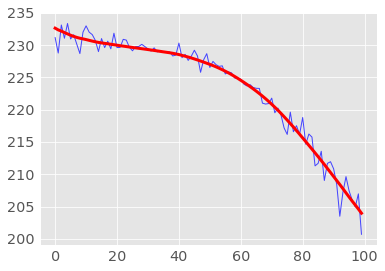

In [55]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

![Results of the convolutional network](img/convolutional-result.png)

![A bigger convolutional network](img/bigger-conv-net.png)

In [56]:
# three convolutional layers with their channel counts, and a
# fully connected layer (the last layer has 10 softmax neurons)
K = 6  # first convolutional layer output depth
L = 12  # second convolutional layer output depth
M = 24  # third convolutional layer
N = 200  # fully connected layer

W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

# The model
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

In [57]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

num_epochs = 100
results = [training_step(i) for i in range(num_epochs)]

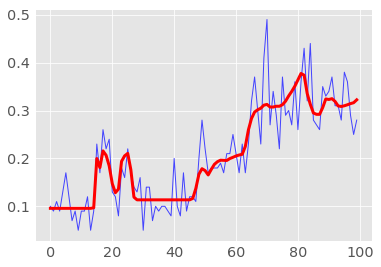

In [58]:
results_tr = list(zip(*results))
a_train, c_train, a_test, c_test = results_tr

plt.plot(range(num_epochs), a_train)
plt.plot(range(num_epochs), a_test, c='red')
plt.show()

In [59]:
a_test[-1]

0.32229999

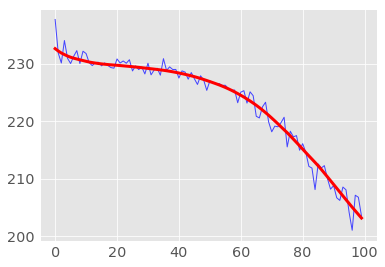

In [60]:
plt.plot(range(num_epochs), c_train)
plt.plot(range(num_epochs), c_test, c='red')
plt.show()

![Result of the bigger network](img/bigger-net-result.png))